# Applying Machine Learning Algorithms to Predict the Stock Price Trend in the stock market - The case of Vietnam
- use S&P500 instead

In [47]:
import yfinance as yf

data = yf.Ticker("SPY").history(period="5y")

In [48]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2019-08-29 00:00:00-04:00,269.626472,270.957415,268.600523,270.421326,57899400,0.0,0.0,0.0
2019-08-30 00:00:00-04:00,271.937116,271.955591,269.349187,270.301178,62901200,0.0,0.0,0.0
2019-09-03 00:00:00-04:00,268.563563,269.497051,267.362003,268.720673,69101400,0.0,0.0,0.0
2019-09-04 00:00:00-04:00,270.938920,271.789227,270.171764,271.770752,46887300,0.0,0.0,0.0
2019-09-05 00:00:00-04:00,274.312535,276.198015,271.733828,275.264526,83258100,0.0,0.0,0.0


### Extract Price and Volume
- "Data is initially collected below, including the following indexes: closing price, opening price, highest price, lowest price and trading volume"

In [49]:
def extract_price_and_vol(data):
    return data.iloc[:, :5]

In [50]:
df = extract_price_and_vol(data)

### Data Cleaning

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Missing Values

In [52]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Data Deviation

In [53]:
def check_suspicious_price(df):
    fig, ax = plt.subplots(4, 1, figsize=(30,20))
    for i in range(4):
        ax[i].scatter(df.index, df.iloc[:,i])
    plt.show()

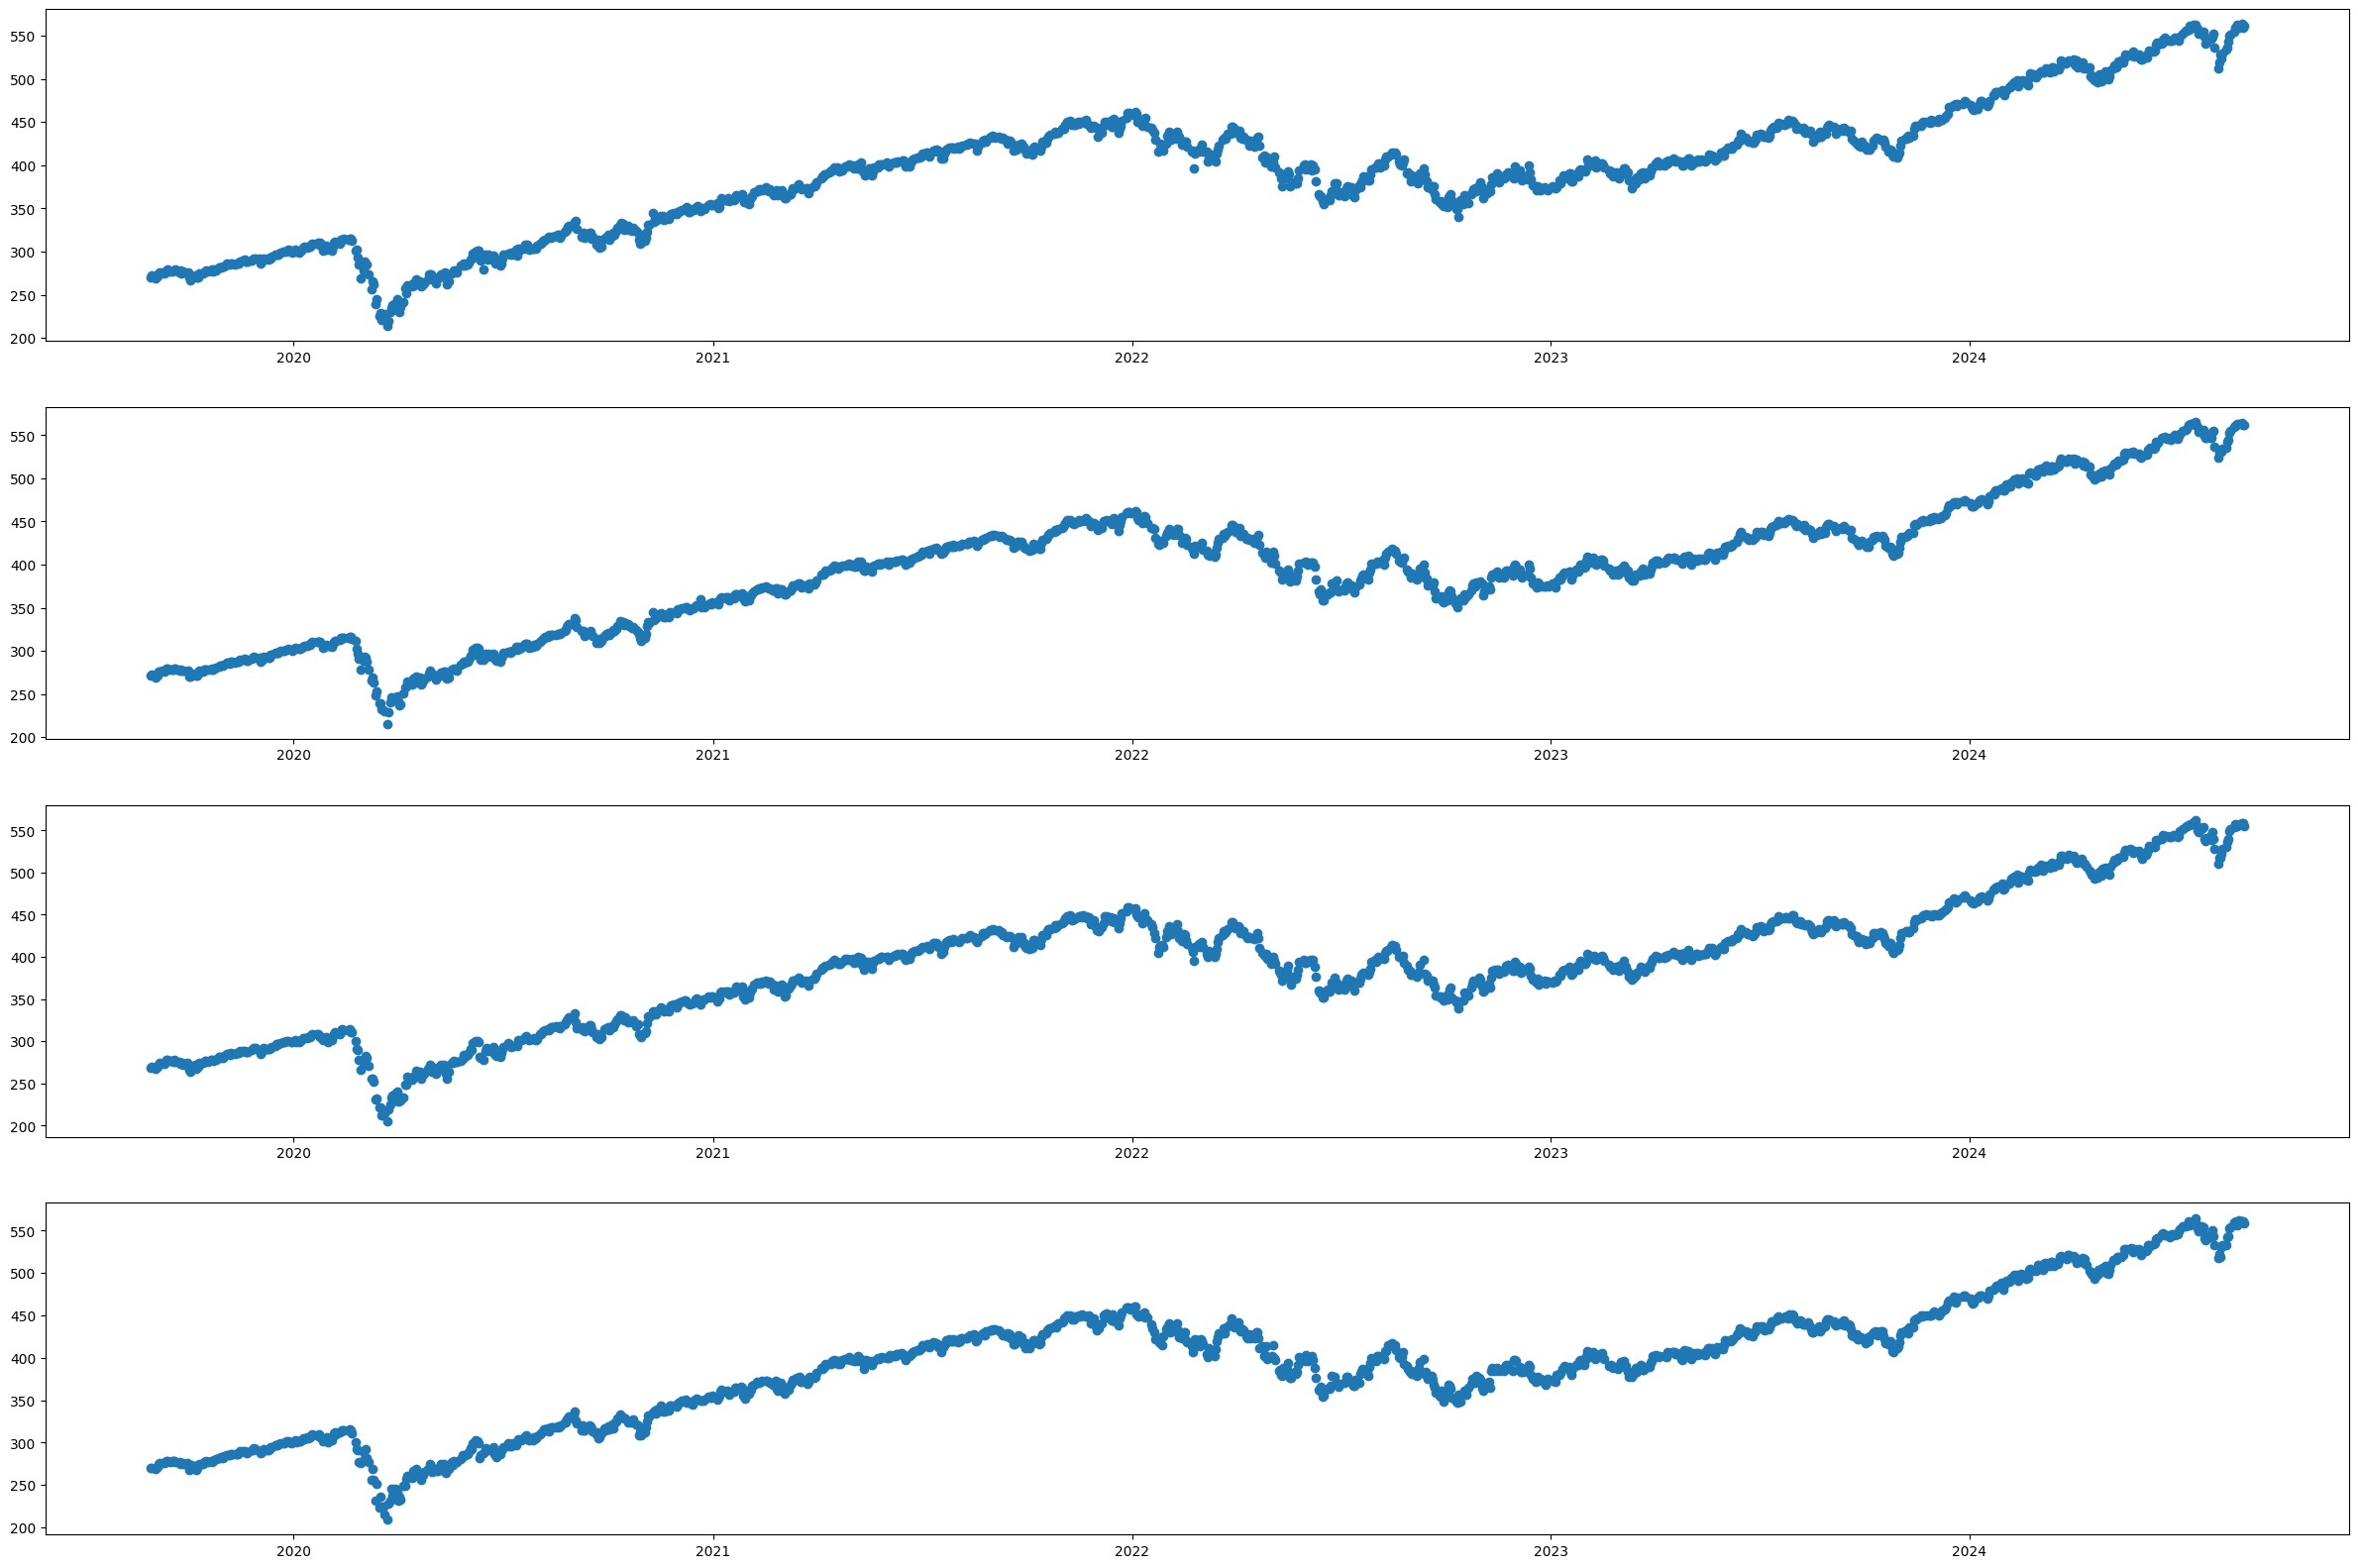

In [54]:
check_suspicious_price(df)

### Calculate Technical Analysis Indicators
- simple moving average (SMA)
- convergence divergence moving average (MACD)
- relative strength index (RSI)

Simple Moving Average (SMA)
- Calculated by summing the recent data points in a given set and dividing the total by the number of time periods. 
- The SMA helps to identify support and resistance prices to obtain signals on where to enter or exit a trade.

In [55]:
def sma(df, windows):
    for window in windows:
        df[f"SMA_{window}"] = df["Close"].rolling(window=window).mean()
    return df

In [56]:
df = sma(df, (20, 50, 200))

Convergence Divergence Moving Average (MACD)
- MACD = 12-period EMA - 26-period EMA

MACD Line
- Reflects the difference between the 12-period and 26-period EMAs, showing the trend direction and momentum.

Interpretation:
- When the MACD Line is positive (i.e., above zero), it indicates that the short-term trend is stronger than the long-term trend, suggesting bullish momentum.
- When the MACD Line is negative (i.e., below zero), it indicates that the short-term trend is weaker than the long-term trend, suggesting bearish momentum.
- Crossovers of the MACD Line with its Signal line can provide potential buy or sell signals.

MACD Histogram
- difference between the MACD Line and the Signal line (a 9-period EMA of the MACD Line). It visually represents the distance between these two lines and is often used to gauge the strength of a trend.

Interpretation:
- Positive Histogram: When the MACD Line is above the Signal line, the histogram is positive, indicating bullish momentum.
- Negative Histogram: When the MACD Line is below the Signal line, the histogram is negative, indicating bearish momentum.
- Increasing Histogram: An increasing histogram (whether positive or negative) suggests that the MACD Line is moving away from the Signal line, indicating strengthening momentum.
- Decreasing Histogram: A decreasing histogram suggests that the MACD Line is approaching the Signal line, indicating weakening momentum

How They Work Together:
 -Trend Confirmation: The MACD Line indicates the trend direction and strength, while the histogram provides a visual representation of the momentum behind that trend.
- Signal Generation: Crossovers between the MACD Line and the Signal line, as represented by the histogram, are key signals for potential buy or sell opportunities.
- Divergence: Divergences between the MACD Histogram and price action can indicate potential reversals. For example, if prices are making new highs, but the MACD Histogram is not, it might suggest weakening momentum and a potential reversal.

In [57]:
def macd(df):
    df["12_EMA"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["26_EMA"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["12_EMA"] - df["26_EMA"]
    
    # Calculate the MACD Histogram
    df['Signal_Line'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']
    return df

Relative Strength Index (RSI)
- RSI measures the speed and magnitude of a security's recent price changes

Interpretation:
- Traditionally, an RSI reading of 70 or above indicates an overbought situation. A reading of 30 or below indicates an oversold condition.

In [58]:
def rsi(df, period=14):
    df["Change"] = df["Close"].diff()

    # Separate gains and losses
    df['Gain'] = df['Change'].where(df['Change'] > 0, 0)
    df['Loss'] = -df['Change'].where(df['Change'] < 0, 0)

    df['Avg_Gain'] = df['Gain'].rolling(window=period).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=period).mean()

    # Calculate the RS (Relative Strength)
    df['RS'] = df['Avg_Gain'] / df['Avg_Loss']

    # Calculate the RSI
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    return df



In [59]:
df = rsi(df)